In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import color
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
time='60min' #time step for the dataset
Office_hour_start=8 #this means 8 AM which office statrs working
Ofice_hour_end=17 #this means 5 PM which office hour ends

In [ ]:
#############################Reading the original dataset and the outdoor data########################
data_original=pd.read_csv("2019Floor6.csv")
outdoo_weather = pd.read_csv("outdoor_weather.csv")
#The number of rows in the outdoo_wreather set should become equal to that of main original data
#Note: The main dataset does not have the data for the end of Nov and Dec. 
outdoo_weather.drop(range(424169,525601), axis=0, inplace=True)

In [ ]:
################################Adding outdoor weather to the main dataset#################################
data=pd.concat([data_original, outdoo_weather[['Outdoor_temp(degC)', 'Radiation(kJ/(hm2))']]], axis=1)

In [ ]:
###################################Omitting unnecessary data###############################################
#Here the first step is to eliminate those months when the sensors are not working.
#Then, the main important step is to keep the office hours data and set others aside. The office hours are set between 8 AM and 5 PM
#Moreover, because the data in the last day is not complete and makes it hard for general loops, so, the data for the last day is omitted as well.
#################################Step 1##############################
# Step 1 description: dropping the months that the sensors are off.
data_wos=data.drop(range(0, 93600), axis=0) #wos stands for without off sensors time

# dropping the last day for the sake of easy coding updating the indexes. 
data_wos=data_wos.drop(labels=range(423360,424169), axis=0).reset_index(drop=True)

#So far, the dataset (data_wos) covers the period between 3/7/2019  12:00:00 AM to 10/21/2019  11:59:00 PM

#################################Step 2##################################
# Step 2 description: keeping the office hours and omitting others.
#Here a loop has been written to omit the time outside the office hours in each day

Number_of_dates=len(data_wos)/(24*60) #this is the number of days in our dataset (24 means 24 hours & 60 is 60 minutes in each hour)
i = 1 #counter for dates (counter of the loop): i=1 means the 3/7/2019 (the start date in our dataset)
#The main loop for dropping unnecessary data is written below:
while i <= Number_of_dates: 
    Day_start_index=(i-1)*(24*60) #index of the start of each day (each day starts exactly from 12 AM)
    Office_start_index=int((i-1)*(24*60)+Office_hour_start*60) #index of the start of the office hour in each day
    Office_end_index=int((i-1)*(24*60)+Ofice_hour_end*60) #index of the end of office hour in each day
    Day_end_index=(i-1)*(24*60)+(24*60)-1 #index of the end of each day (each day ends exactly at 11:59 PM)
#After defining the index of the start and the end of each day as well as the office hours of each day, the data can be cleaned.
#Dropping the data outside the office hours using the above indexes calculated:
    data_wos.drop(range(Day_start_index, Office_start_index),axis=0, inplace= True)
    data_wos.drop(range(Office_end_index+1, Day_end_index+1), axis=0, inplace= True)
    i += 1

In [ ]:
###########################Defining a dataset called data_office_min##############################
#Here we need to define a new dataset called data_office_min. The name of the dataset means:
#offcie: this dataset is only for office hours & min: this dataset is in minute resolution
#Morover, the index of the data_office_min needs to be updated and starts from 0 as below:
data_office_min=data_wos.reset_index(drop=True)

#All the datatypes in the dataset are ok except the first attribute ['Date']. So, it should be modified.
#Changing the data type of the 'Date' attribute to 'datetime64' as follows:
data_office_min['Date']=data_office_min['Date'].astype('datetime64')

In [ ]:
##########################Imputing missing values#######################################
#At this stage, the missing values in each attributes need to be filled with appropriate alternatives
#Filling the missing values with the average of each attribute is a reasonable approach:
from sklearn.impute import SimpleImputer

#The instance object from the model has been named imputer here.
#Note1: The imputer for the 'mean' strategy applied here is for numeric values (this function does work with DateTime attribute)
#Note2: The 'Date' attribute should be omitted here for imputation (actually, it does not have any missing values as well)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_office_min_imputed=pd.DataFrame(imputer.fit_transform(data_office_min.drop(['Date'], axis=1)))
#Imputation process removed the column names. So, we put them back again in the line below:
data_office_min_imputed.columns=data_office_min.columns.drop(['Date'])
#We had to omit the Date column (the first attribute) for imputation. We bring it back to our dataset as below:
data_office_min_clean=pd.concat([data_office_min['Date'], data_office_min_imputed], axis=1)

In [ ]:
#################################Adding loads for each zone together##########################################
#In general, it is a good idea to add different loads of each zone together and create a single attribute for loads in each zone.
#The summation of loads for each zone would be the target (label) attribute in the dataset.
#Adding the plug, lighting, and AC units loads together for each zone using the mapping function as below:
#Note: for using this function, a similar name should be assigned to those attributes that we want to add together.
mapping = {'z1_AC1(kW)'  : 'Zone_1_load(kW)',
           'z1_Light(kW)': 'Zone_1_load(kW)', 
           'z1_Plug(kW)' : 'Zone_1_load(kW)', #Similar name 'Zone_1_load(kW)' for zone 1
           'z2_AC1(kW)'  : 'Zone_2_load(kW)',
           'z2_Light(kW)': 'Zone_2_load(kW)',
           'z2_Plug(kW)' : 'Zone_2_load(kW)', #Similar name 'Zone_2_load(kW)' for zone 2
           'z3_Light(kW)': 'Zone_3_load(kW)',
           'z3_Plug(kW)' : 'Zone_3_load(kW)', #Similar name 'Zone_3_load(kW)' for zone 3
           'z4_AC1(kW)'  : 'Zone_4_load(kW)',
           'z4_AC2(kW)'  : 'Zone_4_load(kW)',
           'z4_AC3(kW)'  : 'Zone_4_load(kW)',
           'z4_AC4(kW)'  : 'Zone_4_load(kW)',
           'z4_Light(kW)': 'Zone_4_load(kW)',
           'z4_Plug(kW)' : 'Zone_4_load(kW)', #Similar name 'Zone_4_load(kW)' for zone 4
           'z5_AC1(kW)'  : 'Zone_5_load(kW)',
           'z5_Light(kW)': 'Zone_5_load(kW)',
           'z5_Plug(kW)' : 'Zone_5_load(kW)'} #Similar name 'Zone_5_load(kW)' for zone 5
#the below line, adds (or groups) these attributes together. 
data_office_min_clean_grouped = data_office_min_clean.set_index('Date').groupby(mapping, axis = 1).sum()
data_office_min_clean_grouped=data_office_min_clean_grouped.reset_index(level = 0)
#The data_office_min_clean_grouped dataframe includes just the above grouped attributes. Other attributes have been lost during the mapping. 
#Therefore, We need to Concatenate all attributes again here:
data_office_min_clean_grouped=pd.concat([data_office_min_clean_grouped['Date'],
                                         data_office_min_clean_grouped['Zone_1_load(kW)'],
                                         data_office_min_clean[['z1_S1(degC)', 'z1_S1(RH%)', 'z1_S1(lux)']].round(decimals=2),
                                         data_office_min_clean_grouped['Zone_2_load(kW)'],
                                         data_office_min_clean[['z2_S1(degC)','z2_S1(RH%)','z2_S1(lux)']].round(decimals=2),
                                         data_office_min_clean_grouped['Zone_3_load(kW)'],
                                         data_office_min_clean_grouped['Zone_4_load(kW)'],
                                         data_office_min_clean[['z4_S1(degC)','z4_S1(RH%)','z4_S1(lux)']].round(decimals=2),
                                         data_office_min_clean_grouped['Zone_5_load(kW)'],
                                         data_office_min_clean[['z5_S1(degC)','z5_S1(RH%)','z5_S1(lux)']].round(decimals=2), 
                                         data_office_min_clean[['Outdoor_temp(degC)','Radiation(kJ/(hm2))']].round(decimals=2)], axis=1)   

In [ ]:
#############Creating different dataset time resolutions & introducing new boolean attributes showing weekends############
data_office=data_office_min_clean_grouped
###################################dataset with X-min interval#############################   
#first, averaging over the time interval:
data_modeling=data_office.groupby([data_office['Date'].transform(pd.to_datetime).dt.floor(freq=time)]).mean().round(decimals=2).reset_index()
#second, adding the new boolean attribute for the weekend:
data_modeling=pd.concat([data_modeling[['Date']], 
                         pd.DataFrame(data=data_modeling['Date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)).rename(columns={'Date': 'Is_weekend?'}),
                         data_modeling.drop('Date', axis=1)], axis=1)

In [ ]:
######################################Omitting the weekends################################
data_modeling.drop(data_modeling.loc[data_modeling['Is_weekend?']==1].index, inplace=True)
data_modeling=data_modeling.reset_index(drop=True)
data_modeling.drop(['Is_weekend?'], axis=1, inplace= True)
data_modeling.drop(['Date'], axis=1, inplace= True)

In [ ]:
######################Creating floor data (summation of loads for all zones)###############
mapping = {'Zone_1_load(kW)'  : 'Floor_6_load(kW)',
           'Zone_2_load(kW)'  : 'Floor_6_load(kW)', 
           'Zone_3_load(kW)'  : 'Floor_6_load(kW)', 
           'Zone_4_load(kW)'  : 'Floor_6_load(kW)',
           'Zone_5_load(kW)'  : 'Floor_6_load(kW)'} 
data_floor_first = data_modeling.set_index('z1_S1(degC)').groupby(mapping, axis = 1).sum()
data_floor_first = data_floor_first.reset_index(level = 0,drop=True)

In [ ]:
######################Creating floor data (averaging over zones for indoor environmental measurements)###############
mapping = {'z1_S1(degC)'  : 'Floor_6_T_(degC)',
           'z2_S1(degC)'  : 'Floor_6_T_(degC)', 
           'z4_S1(degC)'  : 'Floor_6_T_(degC)', 
           'z5_S1(degC)'  : 'Floor_6_T_(degC)',
           'z1_S1(RH%)'   : 'Floor_6_RH_(%)',
           'z2_S1(RH%)'   : 'Floor_6_RH_(%)', 
           'z4_S1(RH%)'   : 'Floor_6_RH_(%)',
           'z5_S1(RH%)'   : 'Floor_6_RH_(%)',
           'z1_S1(lux)'   : 'Floor_6_ill_(lux)',
           'z2_S1(lux)'   : 'Floor_6_ill_(lux)', 
           'z4_S1(lux)'   : 'Floor_6_ill_(lux)', 
           'z5_S1(lux)'   : 'Floor_6_ill_(lux)'}
data_floor_second = data_modeling.set_index('Zone_1_load(kW)').groupby(mapping, sort=False, axis = 1).mean().round(decimals=2)
data_floor_second = data_floor_second.reset_index(level = 0,drop=True)

In [ ]:
######################Creating floor data (joining previous dataframes)###############
data_floor=pd.concat([data_floor_first,
                      data_floor_second,
                      data_modeling[['Outdoor_temp(degC)', 'Radiation(kJ/(hm2))']]], axis=1)

In [ ]:
######################Shuffle the dataframe and creating X and y dataframes###############
data_floor=data_floor.sample(frac=1).reset_index(drop=True)
X = data_floor.iloc[:,[1,2,3,4,5]]
y = data_floor.iloc[:, [0]]

In [ ]:
###################################### Normalization ##############################
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
names_X = X.columns
names_y= y.columns
PredictorScalerFit=scaler.fit(X)
TargetVarScalerFit=scaler.fit(y)
d_X = scaler.fit_transform(X)
X = pd.DataFrame(d_X, columns=names_X)
d_y = scaler.fit_transform(y)
y = pd.DataFrame(d_y, columns=names_y)

In [ ]:
######################### Splitting the dataset into the Training set and Test set####################

from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
#X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(X_train.shape), print(y_train.shape)
#print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1141, 5)
(1141, 1)
(489, 5)
(489, 1)


(None, None)

In [ ]:
regression = LinearRegression()
regression.fit(X=X_train, y=y_train)

LinearRegression()

In [ ]:
y_pred = regression.predict(X = X_test)
act_vs_pred = pd.concat([y_test, 
                         pd.DataFrame(data = y_pred.flatten(), index = y_test.index)], axis = 1)
act_vs_pred.columns = ["Actual Values", "Predicted Values"]
act_vs_pred 

,Actual Values,Predicted Values
1197,0.497642,0.633809
587,0.725484,0.618001
602,0.171817,0.404429
527,0.147585,0.417670
76,0.602293,0.595679
...,...,...
776,0.714994,0.636457
330,0.734591,0.500167
1418,0.158318,0.425773
1235,0.734835,0.663624


In [ ]:
r2 = regression.score(X = X_test, y = y_test)
print("Coefficient of determination (R2):", r2)

Coefficient of determination (R2): 0.6100535985169421


In [ ]:
mse = mean_squared_error(y_true = y_test, y_pred = y_pred)
rmse= mean_squared_error(y_true = y_test, y_pred = y_pred, squared = False)
print("Mean squared error (MSE):", mse)
print("Root mean squared error (RMSE):", rmse)
#calculate MAE
print('Mean Absolute Error:', mae(y_test, y_pred))

Mean squared error (MSE): 0.026089625248442373
Root mean squared error (RMSE): 0.1615228319725802
Mean Absolute Error: 0.12882116790907022


In [ ]:
prediction = regression.predict(X= X_test)
act_vs_pred1 = pd.concat([y_test,
                          pd.DataFrame(data = prediction.flatten(), index = y_test.index)], axis = 1)
act_vs_pred1.columns =["actual", "prediction"]
act_vs_pred1  

,actual,prediction
1197,0.497642,0.633809
587,0.725484,0.618001
602,0.171817,0.404429
527,0.147585,0.417670
76,0.602293,0.595679
...,...,...
776,0.714994,0.636457
330,0.734591,0.500167
1418,0.158318,0.425773
1235,0.734835,0.663624


In [ ]:
act_vs_pred1["Residuals"] = act_vs_pred1["actual"] - act_vs_pred1["prediction"]
act_vs_pred1

,actual,prediction,Residuals
1197,0.497642,0.633809,-0.136167
587,0.725484,0.618001,0.107482
602,0.171817,0.404429,-0.232612
527,0.147585,0.417670,-0.270085
76,0.602293,0.595679,0.006614
...,...,...,...
776,0.714994,0.636457,0.078537
330,0.734591,0.500167,0.234424
1418,0.158318,0.425773,-0.267454
1235,0.734835,0.663624,0.071211


In [ ]:
r2 = r2_score(y_test, prediction)
print("Coefficient of determination (R2):", r2)

Coefficient of determination (R2): 0.6100535985169421


In [ ]:
RMSE = sqrt(mean_squared_error(y_test, prediction))
print('Root Mean Squared Error(RMSE):', sqrt(mean_squared_error(y_test, prediction)))
prediction_orig=TargetVarScalerFit.inverse_transform(prediction)
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

#calculate MAPE
MAPE=(abs(y_test_orig-prediction_orig)/y_test_orig).mean() *100
print('Mean Absolute Percentage Error(MAPE):', MAPE)

Root Mean Squared Error(RMSE): 0.1615228319725802
Mean Absolute Percentage Error(MAPE): 72.66915474196891


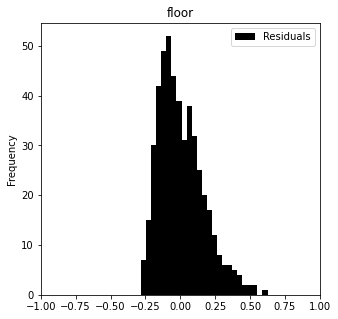

In [ ]:
act_vs_pred1["Residuals"].plot(kind = "hist", bins = 25, legend = True, color = "black", figsize = (5,5), title = "floor",xlim=[-1,1])

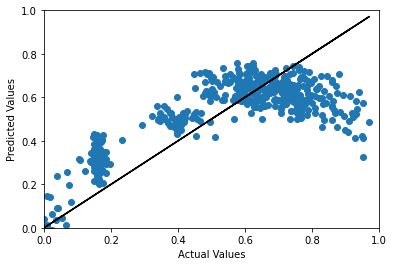

In [ ]:
plt.scatter(y_test,prediction)
plot1=plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot(y_test,y_test, color="black")
plt.show()

In [ ]:
coefficients = pd.DataFrame(data = regression.coef_.flatten(), index = X_train.columns)
intercept = pd.DataFrame(data = regression.intercept_, index = ["Intercept"])

regression_model = coefficients.append(intercept)
regression_model.columns = ['Coefficients']

regression_model

,Coefficients
Floor_6_T_(degC),-1.053278
Floor_6_RH_(%),0.268470
Floor_6_ill_(lux),0.147326
Outdoor_temp(degC),-0.038025
Radiation(kJ/(hm2)),0.222202
Intercept,0.498751


In [ ]:
model = sm.OLS(endog = y_train, exog = sm.add_constant(data=X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Floor_6_load(kW)   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     361.7
Date:                Sun, 17 Apr 2022   Prob (F-statistic):          6.43e-232
Time:                        00:04:08   Log-Likelihood:                 445.69
No. Observations:                1141   AIC:                            -879.4
Df Residuals:                    1135   BIC:                            -849.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4988    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
results.pvalues.round(3).sort_values()

const                  0.000
Floor_6_T_(degC)       0.000
Floor_6_RH_(%)         0.000
Radiation(kJ/(hm2))    0.000
Floor_6_ill_(lux)      0.001
Outdoor_temp(degC)     0.224
dtype: float64

In [ ]:
results.tvalues.round(3).abs().sort_values(ascending = False)

Floor_6_T_(degC)       26.029
Radiation(kJ/(hm2))     9.142
const                   8.918
Floor_6_RH_(%)          5.244
Floor_6_ill_(lux)       3.295
Outdoor_temp(degC)      1.216
dtype: float64

In [ ]:
#feature selection: 
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
sfs = SequentialFeatureSelector(estimator = regression, n_features_to_select=3)
sfs.fit(X=X_train, y=y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=3)

In [ ]:
X_train.columns[sfs.get_support()]

Index(['Floor_6_T_(degC)', 'Floor_6_RH_(%)', 'Radiation(kJ/(hm2))'], dtype='object')

In [ ]:
model = sm.OLS(endog = y_train, exog=sm.add_constant(data = X_train.loc[:, sfs.get_support()]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Floor_6_load(kW)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     593.1
Date:                Sun, 17 Apr 2022   Prob (F-statistic):          5.78e-232
Time:                        00:04:09   Log-Likelihood:                 439.36
No. Observations:                1141   AIC:                            -870.7
Df Residuals:                    1137   BIC:                            -850.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6515    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
regression.fit(X = X_train.loc[:, sfs.get_support()], y=y_train)
prediction1 = regression.predict(X=X_test.loc[:, sfs.get_support()])

rmse1 = mean_squared_error(y_true = y_test, y_pred = prediction1, squared = False)
print("RMSE:", rmse1)
mse1 = mean_squared_error(y_true = y_test, y_pred = prediction1)
print("mse:", mse1)
#calculate MAE
print('Mean Absolute Error:', mae(y_test, prediction1))

RMSE: 0.1614257236252928
mse: 0.02605826424794942
Mean Absolute Error: 0.12842805911544483


In [ ]:
print("\np-values*************\n", results.pvalues.round(3).sort_values())
print("\nt-stat*************\n", results.tvalues.abs().round(3).sort_values(ascending = False))


p-values*************
 const                  0.0
Floor_6_T_(degC)       0.0
Floor_6_RH_(%)         0.0
Radiation(kJ/(hm2))    0.0
dtype: float64

t-stat*************
 const                  41.699
Floor_6_T_(degC)       38.789
Radiation(kJ/(hm2))     9.491
Floor_6_RH_(%)          4.862
dtype: float64
